In [55]:
import pandas as pd
import numpy as np

In [57]:
# TODO: 
# 1. Choose better negative sample (ppl with no complications)
# 2. Try different complications and subset broader
# 3. Subset patients with less than 4 visits
# 4. Preprocess Lab results earlier

In [58]:
# Filtering and processing
# 1. Combine lab and exam sheets
# 2. Lab by 18 desired tests
# 3. Coerce lab & exam values to float
# 4. Remove null for date performed 
# 5. Interquartile ranges
# 6. Datetime

# 7. Disease period range
# 8. Remove redundent visits
# 9. 3 < n < 51


## Modified Start using clean Lab/Exam sheet

In [59]:
#experimental new code
lab = pd.read_csv('FullData/LabExamCleanO10K.csv')
DiseaseCase = pd.read_csv("FullData/DiseaseCase.csv")
# uses different lab tests based on biggest diff. between pos and neg pat sets
tests = ['Alanine Aminotransferase in Serum or Plasma (ALT)',
              'Aspartate Aminotransferase in Serum or Plasma (AST)',
              'Urea (mM)',
              'Plasma Creatinine Clearance (eGFR)',
              'Potassium (mM)',
              'Sodium (mM)',
              'Gamma Glutamyl Transferase in Serum or Plasma (GGT)',
              'Leukocytes in Blood (WBC)',
              'Protein, total (g/L)',
              'Total Cholesterol (TCh)',
              'Total Bilirubin (TBIL)',
              'Platelets in Blood (PLT)',
              'Fasting Blood Glucose (FBG)',
              'Hemoglobin (Hb)',
              'Erythrocytes in Blood (RBC)',
              'Albumin (g/L)',
              'Hemoglobin A1c (HbA1c)',
              'BMI (kg/m^2)']
lab = lab.loc[lab.Name_calc.isin(tests)]
lab['Name_calc'].value_counts()

Hemoglobin (Hb)                                        1276642
Hemoglobin A1c (HbA1c)                                 1269975
Platelets in Blood (PLT)                               1000336
Leukocytes in Blood (WBC)                               997770
Erythrocytes in Blood (RBC)                             951110
Plasma Creatinine Clearance (eGFR)                      936623
Total Cholesterol (TCh)                                 826151
BMI (kg/m^2)                                            793064
Alanine Aminotransferase in Serum or Plasma (ALT)       743651
Fasting Blood Glucose (FBG)                             659506
Aspartate Aminotransferase in Serum or Plasma (AST)     258311
Total Bilirubin (TBIL)                                  243388
Gamma Glutamyl Transferase in Serum or Plasma (GGT)     144289
Sodium (mM)                                             122764
Potassium (mM)                                          116961
Urea (mM)                                              

In [60]:
# 6. Datetime
lab['PerformedDate'] = pd.to_datetime(lab.PerformedDate,format='%Y-%m-%d')

In [109]:
compName = 'DNU'
filename = './positiveSamples/'+compName + '.csv'

In [110]:
disease_periods = pd.read_csv(filename, index_col=None)
disease_periods = disease_periods.drop(disease_periods.columns[0], axis=1)
#if len(disease_periods) > 2000:
 #   disease_periods = disease_periods.iloc[0:2000]
patient_records = lab.loc[lab['Patient_ID'].isin(disease_periods['Patient_ID'])]
patient_records = pd.merge(patient_records, disease_periods, on='Patient_ID')
print(len(patient_records.index),patient_records.columns)
patient_records.head()

507604 Index(['Unnamed: 0', 'Patient_ID', 'PerformedDate', 'Name_calc',
       'TestResult_calc', 'UnitOfMeasure_calc', 'CompOnset', 'DateOfOnset'],
      dtype='object')


,Unnamed: 0,Patient_ID,PerformedDate,Name_calc,TestResult_calc,UnitOfMeasure_calc,CompOnset,DateOfOnset
0,3,1000100164439,2016-06-17,Leukocytes in Blood (WBC),5.8,10^9/L,2014-01-03,2013-02-13
1,4,1000100164439,2016-05-20,Leukocytes in Blood (WBC),7.0,10^9/L,2014-01-03,2013-02-13
2,7,1000100164439,2013-11-06,Platelets in Blood (PLT),239.0,10^9/L,2014-01-03,2013-02-13
3,15,1000100164439,2016-04-15,Leukocytes in Blood (WBC),8.1,10^9/L,2014-01-03,2013-02-13
4,16,1000100164439,2016-02-26,Leukocytes in Blood (WBC),5.6,10^9/L,2014-01-03,2013-02-13


In [111]:
relVisits = patient_records

In [112]:
relVisits.CompOnset = pd.to_datetime(relVisits.CompOnset,format='%Y-%m-%d')
relVisits.DateOfOnset = pd.to_datetime(relVisits.DateOfOnset,format='%Y-%m-%d')

In [113]:
relVisits = patient_records[(patient_records['PerformedDate'] < patient_records['CompOnset']) & (patient_records['PerformedDate'] >= patient_records['DateOfOnset'])]
len(relVisits.index)

247024

In [114]:
pos_Results = relVisits

In [115]:
def get_redundant_indices(resDF, ID, Name, Res):
    p1 = ID == ID[-1:].append(ID[:-1]).reset_index(drop = True)
    p2 = Name == Name[-1:].append(Name[:-1]).reset_index(drop = True)
    p3 = Res == Res[-1:].append(Res[:-1]).reset_index(drop = True)
    return resDF.loc[(p1 & p2 & p3)].index.to_list()

In [116]:
# ## 7. Remove Redundent Visits later
pos_Results = pos_Results.groupby('Patient_ID').apply(lambda g: g.sort_values(by = 'PerformedDate', ascending =True))
#pos_Results = pos_Results.sort_values(by=['Patient_ID','PerformedDate'])
pos_Results = pos_Results.reset_index(drop = True)

rem = get_redundant_indices(pos_Results, pos_Results.Patient_ID, pos_Results.Name_calc, pos_Results.TestResult_calc)
print(len(rem))

1156


In [117]:
## NEW
pos_Results_u = pos_Results
print(len(pos_Results_u.index))
pos_Results_u = pos_Results_u.drop(rem)
print(len(pos_Results_u.index))
print(len(pos_Results_u['Patient_ID'].unique()))

247024
245868
3248


In [118]:
pos_r_final = pos_Results_u[['Patient_ID','PerformedDate']].groupby('Patient_ID').nunique() 
pos_r_final = pos_r_final[(pos_r_final['PerformedDate'] < 51) & (pos_r_final['PerformedDate'] > 3)]
pos_r_final

,PerformedDate
Patient_ID,
1000100001261,30
1000100001339,40
1000100001680,22
1000100001950,37
1000100002046,10
...,...
12120070014244,11
12120120003802,14
12120120026929,10


In [119]:
n = len(pos_r_final.index)
print(n)
posFinal = pos_Results_u[pos_Results_u['Patient_ID'].isin(pos_r_final.index)]
print(len(relVisits.index) / n) # Average results per person
posFinal.head()

2486
99.36604987932422


,Unnamed: 0,Patient_ID,PerformedDate,Name_calc,TestResult_calc,UnitOfMeasure_calc,CompOnset,DateOfOnset
171,68916,1000100001261,2006-01-04,Hemoglobin A1c (HbA1c),9.00,%,2013-10-08,2005-02-14
172,69079,1000100001261,2006-01-04,Total Cholesterol (TCh),4.23,mmol/L,2013-10-08,2005-02-14
173,77715,1000100001261,2006-11-23,Hemoglobin A1c (HbA1c),8.10,%,2013-10-08,2005-02-14
174,80995,1000100001261,2006-11-23,Hemoglobin (Hb),129.00,g/L,2013-10-08,2005-02-14
175,83604,1000100001261,2006-11-23,Platelets in Blood (PLT),235.00,10^9/L,2013-10-08,2005-02-14


In [120]:
# Disease Period
dp = (posFinal['CompOnset'] - posFinal['DateOfOnset']).mean()
print(type(dp))
print(dp)

<class 'pandas._libs.tslibs.timedeltas.Timedelta'>
2422 days 20:56:54.065432928


## Negative Sampling
1. Negative Complement
2. Age and Gender Match
3. Visit Subsetting

In [121]:
# Negative sample part 1
# Import patients with complications
compIDs = pd.read_csv('FullData/compIDs.csv')
compIDs = compIDs['0']

# Negative Complement and demographic matching
from random import sample

PatientInfo = pd.read_csv('FullData/Patient.csv')

all_neg_patients = lab.loc[~lab.Patient_ID.isin(compIDs)].Patient_ID.unique()

pos_patients = posFinal['Patient_ID'].unique()
neg_patients = pd.Series([], dtype = 'int64')
size = len(pos_patients)
#takes 45 sec ish to run
for i in range(size):
    refPatient_ID = pos_patients[i]
    refYOB = PatientInfo.loc[PatientInfo.Patient_ID == refPatient_ID].BirthYear.iloc[0]
    refSex = PatientInfo.loc[PatientInfo.Patient_ID == refPatient_ID].Sex.iloc[0]
    PossiblePatients = PatientInfo.loc[PatientInfo.Patient_ID.isin(all_neg_patients) 
                                       & (PatientInfo.Sex == refSex)]
    
    if refSex != 'Male' and refSex != 'Female':
        continue
    selectedPat = False
    yearGap = 0
    while not selectedPat:
        #print(len(PossiblePatients))
        possible = PossiblePatients.loc[(PossiblePatients.BirthYear >= refYOB - yearGap) 
                                        & (PossiblePatients.BirthYear <= refYOB + yearGap)].Patient_ID
        if len(possible) > 1:
            samp = possible.sample(2)
            selectedPat = samp.iloc[0]
            selectedPat2 = samp.iloc[1]
            neg_patients = neg_patients.append(pd.Series([selectedPat], dtype = 'int64'), ignore_index = True)
            all_neg_patients = all_neg_patients[all_neg_patients != selectedPat]
            neg_patients = neg_patients.append(pd.Series([selectedPat2], dtype = 'int64'), ignore_index = True)
            all_neg_patients = all_neg_patients[all_neg_patients != selectedPat2]

        yearGap += 1
        #else :
         #   print('inf loop')

neg_patients.head()

0     5050070007509
1    12120070003172
2     8080340043098
3     6000600021680
4     4000000600562
dtype: int64

In [122]:
len(neg_patients.index)

4972

In [123]:
# TO DO
# 1. diseaseperiod
# 2. Redundant Visits
# 3. 3 < n < 51

In [124]:
# DiseaseCase
DiseaseCase['Disease'] = DiseaseCase['Disease'].replace("Diabetes Mellitus (ml)","Diabetes Mellitus") # Make all DM2 diagnosis' the same
DiseaseCase['DateOfOnset'] = pd.to_datetime(DiseaseCase.DateOfOnset,format='%Y-%m-%d')
DiseaseCase = DiseaseCase.sort_values(by='DateOfOnset', ascending = True)
DiseaseCase = DiseaseCase.drop_duplicates(subset = ['Patient_ID'])

In [125]:
neg_rec = lab.loc[lab['Patient_ID'].isin(neg_patients)]
neg_rec = pd.merge(neg_rec, DiseaseCase[['Patient_ID','DateOfOnset']], on='Patient_ID')

neg_rec.DateOfOnset = pd.to_datetime(neg_rec.DateOfOnset,format='%Y-%m-%d')

print(len(neg_rec.index)/ len(neg_patients))
neg_rec = neg_rec[neg_rec['PerformedDate'] > neg_rec['DateOfOnset']]
print(len(neg_rec.index)/ len(neg_patients))
print(neg_rec.dtypes)
neg_rec = neg_rec[(neg_rec['PerformedDate'] > neg_rec['DateOfOnset']) & (neg_rec['PerformedDate'] < neg_rec['DateOfOnset']+dp) ]
print(len(neg_rec.index)/ len(neg_patients))

78.43061142397426
61.73672566371681
Unnamed: 0                     int64
Patient_ID                     int64
PerformedDate         datetime64[ns]
Name_calc                     object
TestResult_calc              float64
UnitOfMeasure_calc            object
DateOfOnset           datetime64[ns]
dtype: object
46.142196299275945


In [126]:
# ## 7. Remove Redundent Visits later
neg_rec = neg_rec.groupby('Patient_ID').apply(lambda g: g.sort_values(by = 'PerformedDate', ascending =True))
neg_rec = neg_rec.reset_index(drop = True)
rem = get_redundant_indices(neg_rec, neg_rec.Patient_ID, neg_rec.Name_calc, neg_rec.TestResult_calc)
print(len(rem))

1264


In [127]:
## NEW
neg_rec_u = neg_rec
print(len(neg_rec_u.index))
neg_rec_u = neg_rec_u.drop(rem)
print(len(neg_rec_u.index))
print(len(neg_rec_u['Patient_ID'].unique()))

229419
228155
4578


In [128]:
neg_r_final = neg_rec_u[['Patient_ID','PerformedDate']].groupby('Patient_ID').nunique() 
neg_r_final = neg_r_final[(neg_r_final['PerformedDate'] < 51) & (neg_r_final['PerformedDate'] > 3)]
neg_r_final

,PerformedDate
Patient_ID,
1000100004023,6
1000100006609,7
1000100007073,14
1000100007264,16
1000100007511,14
...,...
12120120025456,5
12120120046608,9
12120120054980,6


In [129]:
negFinal = neg_rec_u.loc[neg_rec_u['Patient_ID'].isin(neg_r_final.index)]
negIDs = negFinal['Patient_ID'].unique()
negFinal.head()

,Unnamed: 0,Patient_ID,PerformedDate,Name_calc,TestResult_calc,UnitOfMeasure_calc,DateOfOnset
4,195277,1000100004023,2007-04-10,Hemoglobin A1c (HbA1c),8.3,%,2003-12-22
5,190278,1000100004023,2007-10-30,Hemoglobin A1c (HbA1c),7.3,%,2003-12-22
6,195110,1000100004023,2008-11-30,Hemoglobin A1c (HbA1c),7.6,%,2003-12-22
7,195418,1000100004023,2009-06-08,Hemoglobin A1c (HbA1c),7.9,%,2003-12-22
8,195381,1000100004023,2009-12-21,Hemoglobin A1c (HbA1c),8.3,%,2003-12-22


In [130]:
t1 = []
t2 = []
for test in tests:
    t1.append(lab.loc[lab.Name_calc == test].TestResult_calc.quantile(0.3333))
    t2.append(lab.loc[lab.Name_calc == test].TestResult_calc.quantile(0.6667))

turtiles2 = pd.DataFrame(data = {'t1' : t1, 't2' : t2}, index = tests)

#turtiles = pd.read_csv('TestTurtiles.csv')

In [131]:
turtiles2.head(18)

,t1,t2
Alanine Aminotransferase in Serum or Plasma (ALT),19.00,28.00000
Aspartate Aminotransferase in Serum or Plasma (AST),19.00,25.00000
Urea (mM),5.00,6.60000
Plasma Creatinine Clearance (eGFR),60.00,84.00000
Potassium (mM),4.20,4.60000
Sodium (mM),139.00,141.00000
Gamma Glutamyl Transferase in Serum or Plasma (GGT),23.00,41.00000
Leukocytes in Blood (WBC),6.20,7.90000
"Protein, total (g/L)",NaN,NaN
Total Cholesterol (TCh),3.67,4.63000


In [132]:
turtiles = pd.read_csv('TestTurtiles.csv')
turtiles.head(18)

,Unnamed: 0,TestName,t1,t2
0,0,Alanine Aminotransferase in Serum or Plasma (ALT),18.000000,27.00
1,1,Aspartate Aminotransferase in Serum or Plasma ...,18.000000,24.00
2,2,Urea (mM),5.100000,6.70
3,3,Plasma Creatinine Clearance (eGFR),60.000000,83.00
4,4,Potassium (mM),4.200000,4.60
5,5,Sodium (mM),139.000000,141.00
6,6,Gamma Glutamyl Transferase in Serum or Plasma ...,23.000000,41.00
7,7,Leukocytes in Blood (WBC),6.200000,7.90
8,8,"Protein, total (g/L)",63.000000,71.00
9,9,Total Cholesterol (TCh),3.530000,4.39


In [133]:
Results = pd.concat([posFinal, negFinal], ignore_index = True)
Results.head()

,Unnamed: 0,Patient_ID,PerformedDate,Name_calc,TestResult_calc,UnitOfMeasure_calc,CompOnset,DateOfOnset
0,68916,1000100001261,2006-01-04,Hemoglobin A1c (HbA1c),9.00,%,2013-10-08,2005-02-14
1,69079,1000100001261,2006-01-04,Total Cholesterol (TCh),4.23,mmol/L,2013-10-08,2005-02-14
2,77715,1000100001261,2006-11-23,Hemoglobin A1c (HbA1c),8.10,%,2013-10-08,2005-02-14
3,80995,1000100001261,2006-11-23,Hemoglobin (Hb),129.00,g/L,2013-10-08,2005-02-14
4,83604,1000100001261,2006-11-23,Platelets in Blood (PLT),235.00,10^9/L,2013-10-08,2005-02-14


In [134]:
def bin_vals(tests, values, turtiles):
    binned_vals = np.zeros(len(tests))
    
    binned_vals[Results['TestResult_calc'].values <= turtiles['t1'][Results['Name_calc'].values].values] = 1.0
    binned_vals[Results['TestResult_calc'].values >= turtiles['t2'][Results['Name_calc'].values].values] = 3.0
    binned_vals[binned_vals == 0.0] = 2.0

    return binned_vals
        
Results['TestResult_calc'] = bin_vals(Results['Name_calc'].values, Results['TestResult_calc'].values, turtiles2)
Results.head() 

,Unnamed: 0,Patient_ID,PerformedDate,Name_calc,TestResult_calc,UnitOfMeasure_calc,CompOnset,DateOfOnset
0,68916,1000100001261,2006-01-04,Hemoglobin A1c (HbA1c),3.0,%,2013-10-08,2005-02-14
1,69079,1000100001261,2006-01-04,Total Cholesterol (TCh),2.0,mmol/L,2013-10-08,2005-02-14
2,77715,1000100001261,2006-11-23,Hemoglobin A1c (HbA1c),3.0,%,2013-10-08,2005-02-14
3,80995,1000100001261,2006-11-23,Hemoglobin (Hb),2.0,g/L,2013-10-08,2005-02-14
4,83604,1000100001261,2006-11-23,Platelets in Blood (PLT),2.0,10^9/L,2013-10-08,2005-02-14


In [135]:
Results.groupby('TestResult_calc').agg('count')

,Unnamed: 0,Patient_ID,PerformedDate,Name_calc,UnitOfMeasure_calc,CompOnset,DateOfOnset
TestResult_calc,,,,,,,
1.0,154540,154540,154540,154540,154540,75118,154540
2.0,117996,117996,117996,117996,117996,50529,117996
3.0,111378,111378,111378,111378,111378,48027,111378


In [136]:
Results = Results.groupby('Patient_ID').apply(lambda g: g.sort_values(by = 'PerformedDate', ascending =True))
Results = Results.reset_index(drop = True)
    
rem = get_redundant_indices(Results, Results.Patient_ID, Results.Name_calc, Results.TestResult_calc)

print(len(rem))


14082


In [137]:
Results_u = Results
print(len(Results_u.index))
Results_u = Results_u.drop(rem)
print(len(Results_u.index))

383914
369832


In [138]:
AllVisits = {}
VisitValues = {}
for index, row in Results_u.iterrows() :
    temp = (str(row['Patient_ID']),str(row['PerformedDate']))
    diag = (row['Name_calc'],row['TestResult_calc'])
    if temp not in AllVisits.keys():
        AllVisits[temp] = []
    AllVisits[temp] = AllVisits[temp] + [diag]

PVDF = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in AllVisits.items() ]))
PVDF = PVDF.transpose()
PVDF = PVDF.dropna(axis=0,how='all') # Remove NA


In [139]:
eTests = []
for t in tests :
    for i in range(1,4) :
        eTests.append(t+str(i))

In [140]:
RowFeatures = pd.DataFrame(data = 0,
                       index = PVDF.index,
                       columns=eTests)
RowFeatures

Alanine Aminotransferase in Serum or Plasma (ALT)1  \
1000100001261  2006-01-04 00:00:00                                                  0    
               2006-11-23 00:00:00                                                  0    
               2008-01-03 00:00:00                                                  0    
               2008-04-23 00:00:00                                                  0    
               2008-12-30 00:00:00                                                  0    
...                                                                               ...    
12120120057733 2017-10-23 00:00:00                                                  0    
12120120077424 2018-12-13 00:00:00                                                  0    
               2019-06-18 00:00:00                                                  0    
               2019-09-23 00:00:00                                                  0    
               2019-12-23 00:00:00                                                  0    

                                    Alanine Aminotransferase in Serum or Plasma (ALT)2  \
1000100001261  2006-01-04 00:00:00                                                  0    
               2006-11-23 00:00:00                                                  0    
               2008-01-03 00:00:00                                                  0    
               2008-04-23 00:00:00                                                  0    
               2008-12-30 00:00:00                                                  0    
...                                                                               ...    
12120120057733 2017-10-23 00:00:00                                                  0    
12120120077424 2018-12-13 00:00:00                                                  0    
               2019-06-18 00:00:00                                                  0    
               2019-09-23 00:00:00                                                  0    
               2019-12-23 00:00:00                                                  0    

                                    Alanine Aminotransferase in Serum or Plasma (ALT)3  \
1000100001261  2006-01-04 00:00:00                                                  0    
               2006-11-23 00:00:00                                                  0    
               2008-01-03 00:00:00                                                  0    
               2008-04-23 00:00:00                                                  0    
               2008-12-30 00:00:00                                                  0    
...                                                                               ...    
12120120057733 2017-10-23 00:00:00                                                  0    
12120120077424 2018-12-13 00:00:00                                                  0    
               2019-06-18 00:00:00                                                  0    
               2019-09-23 00:00:00                                                  0    
               2019-12-23 00:00:00                                                  0    

                                    Aspartate Aminotransferase in Serum or Plasma (AST)1  \
1000100001261  2006-01-04 00:00:00                                                  0      
               2006-11-23 00:00:00                                                  0      
               2008-01-03 00:00:00                                                  0      
               2008-04-23 00:00:00                                                  0      
               2008-12-30 00:00:00                                                  0      
...                                                                               ...      
12120120057733 2017-10-23 00:00:00                                                  0      
12120120077424 2018-12-13 00:00:00                       

In [141]:
for index, row in RowFeatures.iterrows() :
    temp = PVDF.loc[index].dropna()
    for t in temp :
        test = t[0] + str(int(t[1]))
        row[test] = 1
RowFeatures

Alanine Aminotransferase in Serum or Plasma (ALT)1  \
1000100001261  2006-01-04 00:00:00                                                  0    
               2006-11-23 00:00:00                                                  0    
               2008-01-03 00:00:00                                                  1    
               2008-04-23 00:00:00                                                  0    
               2008-12-30 00:00:00                                                  1    
...                                                                               ...    
12120120057733 2017-10-23 00:00:00                                                  1    
12120120077424 2018-12-13 00:00:00                                                  0    
               2019-06-18 00:00:00                                                  0    
               2019-09-23 00:00:00                                                  0    
               2019-12-23 00:00:00                                                  0    

                                    Alanine Aminotransferase in Serum or Plasma (ALT)2  \
1000100001261  2006-01-04 00:00:00                                                  0    
               2006-11-23 00:00:00                                                  0    
               2008-01-03 00:00:00                                                  0    
               2008-04-23 00:00:00                                                  0    
               2008-12-30 00:00:00                                                  0    
...                                                                               ...    
12120120057733 2017-10-23 00:00:00                                                  0    
12120120077424 2018-12-13 00:00:00                                                  0    
               2019-06-18 00:00:00                                                  0    
               2019-09-23 00:00:00                                                  0    
               2019-12-23 00:00:00                                                  0    

                                    Alanine Aminotransferase in Serum or Plasma (ALT)3  \
1000100001261  2006-01-04 00:00:00                                                  0    
               2006-11-23 00:00:00                                                  0    
               2008-01-03 00:00:00                                                  0    
               2008-04-23 00:00:00                                                  0    
               2008-12-30 00:00:00                                                  0    
...                                                                               ...    
12120120057733 2017-10-23 00:00:00                                                  0    
12120120077424 2018-12-13 00:00:00                                                  0    
               2019-06-18 00:00:00                                                  0    
               2019-09-23 00:00:00                                                  0    
               2019-12-23 00:00:00                                                  0    

                                    Aspartate Aminotransferase in Serum or Plasma (AST)1  \
1000100001261  2006-01-04 00:00:00                                                  0      
               2006-11-23 00:00:00                                                  0      
               2008-01-03 00:00:00                                                  0      
               2008-04-23 00:00:00                                                  0      
               2008-12-30 00:00:00                                                  0      
...                                                                               ...      
12120120057733 2017-10-23 00:00:00                                                  0      
12120120077424 2018-12-13 00:00:00                       

In [142]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 18)
visits_emb = svd.fit_transform(RowFeatures)
reducedDF = pd.DataFrame(data=visits_emb, index=RowFeatures.index)

In [143]:
IDs = negIDs

In [144]:
#EXPERIMENTAL VERSION
'''
VisitHistorySVD = {}
for index, row in RowFeatures.iterrows() :
    temp = int(index[0])
    featureVector = list(row)
    if temp not in VisitHistorySVD.keys():
        if temp in IDs :
            VisitHistorySVD[temp] = [0]
        else :
            VisitHistorySVD[temp] = [1]
    VisitHistorySVD[temp] = VisitHistorySVD[temp] + featureVector'''

'\nVisitHistorySVD = {}\nfor index, row in RowFeatures.iterrows() :\n    temp = int(index[0])\n    featureVector = list(row)\n    if temp not in VisitHistorySVD.keys():\n        if temp in IDs :\n            VisitHistorySVD[temp] = [0]\n        else :\n            VisitHistorySVD[temp] = [1]\n    VisitHistorySVD[temp] = VisitHistorySVD[temp] + featureVector'

In [145]:
VisitHistorySVD = {}
for index, row in reducedDF.iterrows() :
    temp = int(index[0])
    featureVector = list(row)
    if temp not in VisitHistorySVD.keys():
        if temp in IDs :
            VisitHistorySVD[temp] = [0]
        else :
            VisitHistorySVD[temp] = [1]
    VisitHistorySVD[temp] = VisitHistorySVD[temp] + featureVector

In [146]:
m = [0]
for k,v in VisitHistorySVD.items() :
    temp = len(v)
    if temp > m[-1] :
        m.append(k)
        m.append(temp)
        
print(m)

[0, 1000100001261, 523, 1000100001339, 721, 1000100002400, 829, 1000100007128, 847, 1000100191274, 901]


In [147]:
#EXPERIMETAL VERSION
'''
# Fill in to 2700
for k,v in VisitHistorySVD.items() :
    fillLen = 2701 - len(v)
    VisitHistorySVD[k] = v + [0]*fillLen'''
    

'\n# Fill in to 2700\nfor k,v in VisitHistorySVD.items() :\n    fillLen = 2701 - len(v)\n    VisitHistorySVD[k] = v + [0]*fillLen'

In [148]:
# Fill in to 900
for k,v in VisitHistorySVD.items() :
    fillLen = 901 - len(v)
    VisitHistorySVD[k] = v + [0]*fillLen
    

In [149]:
inputData = pd.DataFrame.from_dict(VisitHistorySVD).T
inputData.to_csv('./LabModelData/'+compName+'.csv')

In [150]:
# MODELING
# Convert data to x y
x, y = [], []
for k,v in VisitHistorySVD.items() :
    if v[0] == 1 :
        y.append([1,0])
    if v[0] == 0 :
        y.append([0,1])
    x.append(v[1:])

print(len(x), len(y))

6232 6232


In [151]:
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding,GRU, LSTM, GlobalMaxPooling1D, SpatialDropout1D, GRU, Bidirectional, Input, TimeDistributed, Reshape

In [152]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.10, shuffle = True)
print(len(x_train), 'training')
print(len(x_test), 'testing')
#print(x_test[:10], y_test[:10])

5608 training
624 testing


In [153]:
#x_test[0]

In [154]:
# Bidirectional GRU

# Random search drop out rate and number of units/neurons
x_train = np.array(x_train)
x_test = np.array(x_test)
input_shape = (x_train.shape[1], 1) # 900,1

units = 100


model = Sequential()
#model.add(Reshape((50, 54), input_shape=(2700,))) #change input shape and reshape
model.add(Reshape((50, 18), input_shape=(900,)))
# 1 sees the past 
# 2 sees the past and the future


dropout = 0.2 # for regularization
print('Number of hidden units: ', units, 'Dropout: ', dropout)
model.add(Bidirectional(GRU(units, input_shape=input_shape))) # 64, $128$, 256, 512
model.add(Dropout(dropout))
model.add(Dense(2, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print('Training...')
history = model.fit(
    np.array(x_train),
    np.array(y_train),
    batch_size = 128, 
    epochs = 25,
    validation_split = 0.10
)




Number of hidden units:  100 Dropout:  0.2
Training...
Epoch 1/25
40/40 [==============================] - 8s 88ms/step - loss: 0.6702 - accuracy: 0.5894 - val_loss: 0.6202 - val_accuracy: 0.6774
Epoch 2/25
40/40 [==============================] - 3s 63ms/step - loss: 0.6073 - accuracy: 0.6739 - val_loss: 0.6157 - val_accuracy: 0.6738
Epoch 3/25
40/40 [==============================] - 3s 63ms/step - loss: 0.5939 - accuracy: 0.6803 - val_loss: 0.5936 - val_accuracy: 0.6898
Epoch 4/25
40/40 [==============================] - 3s 64ms/step - loss: 0.5800 - accuracy: 0.6872 - val_loss: 0.5898 - val_accuracy: 0.6970
Epoch 5/25
40/40 [==============================] - 3s 64ms/step - loss: 0.5688 - accuracy: 0.7001 - val_loss: 0.5898 - val_accuracy: 0.7094
Epoch 6/25
40/40 [==============================] - 3s 63ms/step - loss: 0.5732 - accuracy: 0.6925 - val_loss: 0.5877 - val_accuracy: 0.7184
Epoch 7/25
40/40 [==============================] - 2s 62ms/step - loss: 0.5464 - accuracy: 0.7203 

In [155]:
print(model.evaluate(x_test, np.array(y_test)))
preds = model.predict(x_test)

20/20 [==============================] - 0s 8ms/step - loss: 0.5536 - accuracy: 0.7131
[0.5535644888877869, 0.7131410241127014]


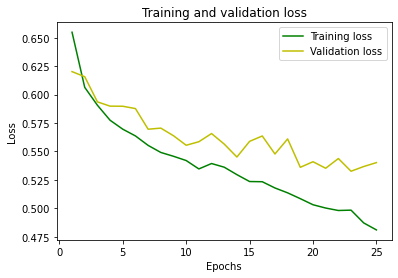

In [156]:
from matplotlib import pyplot as plt
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [157]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds)

0.790338369865929

In [235]:
# 70s val accuracy, 50-low60s test accuracy LSTM BOOHOO
# 67 val accuracy, 73% accuracy, auc_roc 0.836 GRU
# 0.7426 val accuracy, 0.7815 accuracy, roc 0.8745557924662403 GRU

In [236]:
# TODOS : 
# 1. Check features
# 2. Try without SVD
# 3. Try with different diseases
# 4. 